In [1]:
from IPython.display import display
import ipywidgets as widgets

# Створення віджету для завантаження файлу
upload_widget = widgets.FileUpload(accept='.txt', multiple=False)

def handle_upload(change):
    # Отримуємо файл
    uploaded_file = list(upload_widget.value.values())[0]
    content = uploaded_file['content'].decode('utf-8')  # Декодуємо вміст файлу
    print("Перші 500 символів корпусу:\n")
    print(content[:500])  # Показуємо перші символи
    # Зберігаємо в змінну
    global corpus_text
    corpus_text = content

upload_widget.observe(handle_upload, names='value')
display(upload_widget)


FileUpload(value={}, accept='.txt', description='Upload')

Перші 500 символів корпусу:

                        Замкнена кімната
                                     Пер Вале

    Май Шеваль, Пер Вале
    Замкнена кімната
    Переклад Ольги Сенюк
    I
    На вежі Маріїнської церкви вибило другу годину, коли вона вийшла з метро на
станції Вольмар-Ікскюлсгатан. Зупинившись, вона закурила, тоді швидко рушила в бік
Маріїнської площі.
    Відгомін дзвону, що тремтів у повітрі, нагадав їй безрадісні неділі дитинства. Вона
народилась і виросла .всього за кілька кварталів від М


In [2]:
import numpy as np
from collections import defaultdict
import re


def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    return words


def build_vocab(words):
    vocab = sorted(set(words))
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}
    return word2idx, idx2word


def generate_cbow_data(words, word2idx, window_size=2):
    data = []
    for i in range(window_size, len(words) - window_size):
        context = [words[i - j] for j in range(window_size, 0, -1)] + \
                  [words[i + j] for j in range(1, window_size + 1)]
        target = words[i]
        data.append((context, target))
    return [
        ([word2idx[w] for w in context], word2idx[target])
        for context, target in data
    ]


In [3]:
import numpy as np

class CBOW:
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        # Ініціалізація ваг
        self.W1 = np.random.randn(vocab_size, embedding_dim)
        self.W2 = np.random.randn(embedding_dim, vocab_size)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def forward(self, context_idxs):
        # Embedding для контекстних слів
        self.h = np.mean(self.W1[context_idxs], axis=0)  # (embedding_dim,)
        self.u = np.dot(self.W2.T, self.h)  # (vocab_size,)
        self.y_pred = self.softmax(self.u)  # (vocab_size,)
        return self.y_pred

    def backward(self, context_idxs, target_idx, learning_rate):
        # One-hot ціль
        y_true = np.zeros(self.vocab_size)
        y_true[target_idx] = 1

        error = self.y_pred - y_true  # (vocab_size,)

        # Градієнти
        dW2 = np.outer(self.h, error)  # (embedding_dim x vocab_size)
        dW1 = np.dot(self.W2, error) / len(context_idxs)  # (embedding_dim,)

        # Оновлення ваг
        self.W2 -= learning_rate * dW2
        for idx in context_idxs:
            self.W1[idx] -= learning_rate * dW1

    def train(self, data, epochs=10, learning_rate=0.05):
        for epoch in range(epochs):
            loss = 0
            for context_idxs, target_idx in data:
                self.forward(context_idxs)
                self.backward(context_idxs, target_idx, learning_rate)
                loss -= np.log(self.y_pred[target_idx] + 1e-7)
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")


In [4]:
# 1. Підготовка даних
words = preprocess_text(corpus_text)
word2idx, idx2word = build_vocab(words)
training_data = generate_cbow_data(words, word2idx, window_size=2)

# 2. Створення та навчання моделі
cbow_model = CBOW(vocab_size=len(word2idx), embedding_dim=50)
cbow_model.train(training_data, epochs=20, learning_rate=0.05)


Epoch 1, Loss: 788562.7251
Epoch 2, Loss: 647218.6980
Epoch 3, Loss: 581603.6444
Epoch 4, Loss: 536113.0585
Epoch 5, Loss: 500315.1280
Epoch 6, Loss: 470296.7138
Epoch 7, Loss: 444108.2233
Epoch 8, Loss: 420640.9847
Epoch 9, Loss: 399211.3658
Epoch 10, Loss: 379368.6996
Epoch 11, Loss: 360805.7528
Epoch 12, Loss: 343310.3778
Epoch 13, Loss: 326732.9955
Epoch 14, Loss: 310965.5398
Epoch 15, Loss: 295928.3976
Epoch 16, Loss: 281561.6748
Epoch 17, Loss: 267819.8839
Epoch 18, Loss: 254668.4168
Epoch 19, Loss: 242080.9705
Epoch 20, Loss: 230037.7113


In [5]:
from numpy.linalg import norm

def get_vector(word):
    idx = word2idx.get(word)
    if idx is None:
        print(f"Слово '{word}' не знайдено в словнику.")
        return None
    return cbow_model.W1[idx]

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2) + 1e-8)

def most_similar(word, top_n=5):
    vec = get_vector(word)
    if vec is None:
        return

    similarities = {}
    for other_word in word2idx:
        if other_word == word:
            continue
        other_vec = get_vector(other_word)
        sim = cosine_similarity(vec, other_vec)
        similarities[other_word] = sim

    # Сортуємо за схожістю
    similar_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    print(f"\nНайбільш подібні до '{word}':")
    for w, sim in similar_words[:top_n]:
        print(f"{w}: {sim:.4f}")


In [6]:
most_similar("церква")
most_similar("дитинства")


Слово 'церква' не знайдено в словнику.

Найбільш подібні до 'дитинства':
досліджень: 0.5600
працівникам: 0.5354
організації: 0.5149
водій: 0.5125
розійдуться: 0.4936


In [7]:
print([w for w in word2idx if 'церк' in w])


['церкви']


In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_word_vectors(words_to_plot=None, max_words=100):
    if words_to_plot is None:
        words_to_plot = list(word2idx.keys())[:max_words]

    vectors = np.array([get_vector(w) for w in words_to_plot])

    # Застосування PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    # Побудова графіку
    plt.figure(figsize=(12, 8))
    for i, word in enumerate(words_to_plot):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)
    plt.title("Word Embeddings PCA")
    plt.grid(True)
    plt.show()


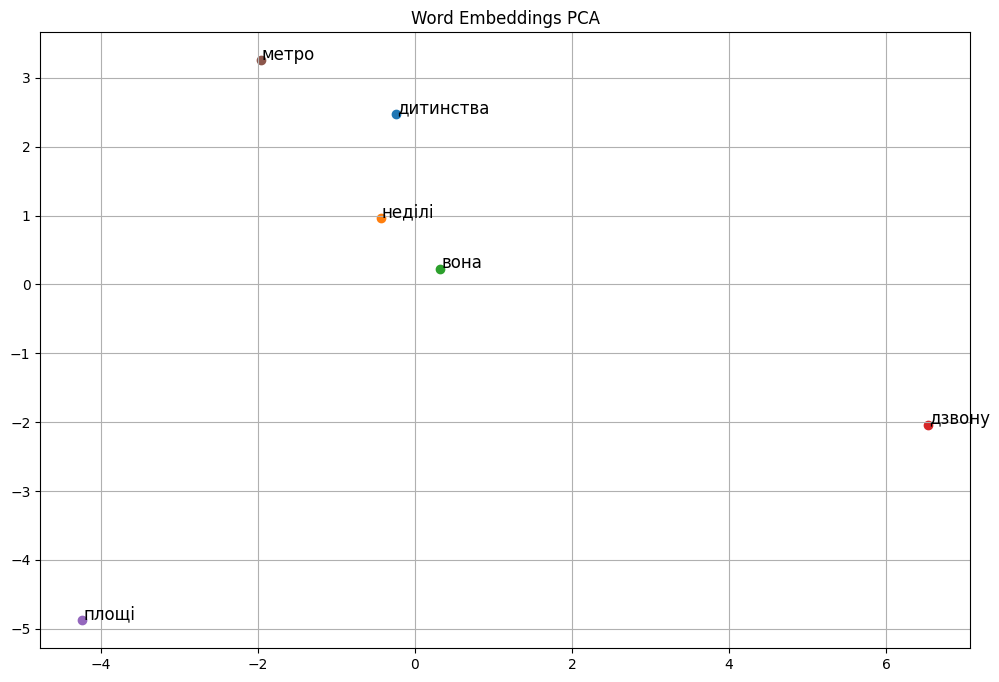

In [11]:
plot_word_vectors(["дитинства", "неділі", "вона", "дзвону", "площі", "метро"])


In [12]:
def save_embeddings(filename="word_vectors.txt"):
    with open(filename, "w", encoding="utf-8") as f:
        for word, idx in word2idx.items():
            vector = cbow_model.W1[idx]
            vec_str = " ".join(map(str, vector))
            f.write(f"{word} {vec_str}\n")
    print(f"✅ Вектори збережено у файл: {filename}")


In [13]:
save_embeddings("cbow_vectors.txt")


✅ Вектори збережено у файл: cbow_vectors.txt


In [14]:
from google.colab import files
files.download("cbow_vectors.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [16]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Ввід слова
word_input = widgets.Text(
    value='дитинства',
    placeholder='Введіть слово...',
    description='Слово:',
    disabled=False
)

# Кнопка пошуку
search_button = widgets.Button(
    description='Знайти схожі',
    button_style='success'
)

# Вивід результатів
output = widgets.Output()

# Функція, яка спрацьовує при натисканні кнопки
def on_button_clicked(b):
    with output:
        clear_output()
        word = word_input.value.strip()
        most_similar(word)

# Прив'язка події
search_button.on_click(on_button_clicked)

# Відображення інтерфейсу
display(word_input, search_button, output)


Text(value='дитинства', description='Слово:', placeholder='Введіть слово...')

Button(button_style='success', description='Знайти схожі', style=ButtonStyle())

Output()

In [17]:
import json

def save_vectors_to_json(filename="cbow_vectors.json"):
    vectors_dict = {}
    for word, idx in word2idx.items():
        vector = cbow_model.W1[idx]
        vectors_dict[word] = vector.tolist()  # Перетворення в список для JSON

    with open(filename, "w", encoding="utf-8") as f:
        json.dump(vectors_dict, f, ensure_ascii=False, indent=2)

    print(f"✅ Вектори збережено у файл: {filename}")


In [18]:
save_vectors_to_json("cbow_vectors.json")


✅ Вектори збережено у файл: cbow_vectors.json


In [19]:
from google.colab import files
files.download("cbow_vectors.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>